In [8]:
import _background as bg
import pandas as pd
import numpy as np

from molNet.featurizer.featurizer import FeaturizerList
from molNet.featurizer.atom_featurizer import atom_symbol_one_hot_from_set,atom_chiral_tag_one_hot,atom_total_num_H_one_hot, atom_formal_charge, atom_partial_charge, atom_hybridization_one_hot, atom_is_in_ring_size_3_to_20_one_hot, atom_is_aromatic, atom_is_in_ring, atom_total_degree_one_hot
from molNet.dataloader.molecule_loader import PytorchGeomMolDfLoader

import pytorch_lightning as pl
import torch
import molNet

In [2]:
#for batch in loader_MPModel1.train_dataloader():
#    print(batch)
#    break
#dir(molNet)

In [13]:
dataset=pd.read_csv("data/patents_ochem_enamine_bradley_begstrom_training_edit.csv")
#dataset=dataset[dataset["mpC"]>=0]
#dataset=dataset[dataset["mpC"]<=180]
print(len(dataset))
#dataset["rd_mol"]=dataset["smiles"].apply(bg.pd_MolFromSmiles)
dataset["mpK"]= dataset["mpC"]+273
dataset["logmpK"]=np.log(dataset["mpK"])
from molNet.featurizer.featurizer import OneHotFeaturizer

def _get_atom_symbol(atom):
    return atom.GetSymbol()

c_mp_atom_symbol_featurizer = OneHotFeaturizer(
    possible_values=['O', 'Si', 'Na', 'H', 'P', 'F', 'S', 'C', 'Cl', 'N', 'B', 'Br','I',None],
    pre_featurize=_get_atom_symbol,
    name="atom_symbol_one_hot",
)

featurizer = FeaturizerList([
    c_mp_atom_symbol_featurizer,
    atom_total_degree_one_hot,
    atom_formal_charge,
    atom_partial_charge,
    atom_chiral_tag_one_hot,
    #atom_total_num_H_one_hot,
    atom_hybridization_one_hot,
    atom_is_aromatic,
    atom_is_in_ring,
])
len(featurizer)

275121


38

In [3]:
loader_MPModel1 = PytorchGeomMolDfLoader(dataset,mol_create_source='smiles',#"all",
                                    atom_featurizer=featurizer,
                                         columns=[],
                                         y_columns=["mpK"],
#                                     y_properties=["mpK"],
                                     seed=1,
#                                     to_graph_params={
 #                                        "atom_featurizer":featurizer,
  #                                       "with_mol_graph":True
   #                                  },
                                    batch_size=2**8,#num_workers=4
                                    path="test/mp1.pckl",
                                    #follow_batch=["y"]
                                             #     num_workers=28
                                        # to_graph_input_kwargs=dict(keep_string_data=True,include_graph_features_titles=True)
                                         
                                    )
#loader_MPModel1.setup()
#https://www.wonder.me/r?id=d074588c-c7ab-4a0a-a0fd-bd075a1473d0


[I 2021-03-23 11:05:59,944] Using an existing study with name 'tune_study' instead of creating a new one.


{'use_pool_min': True,
 'use_pool_max': False,
 'use_pool_mean': False,
 'use_pool_sum': True,
 'use_pool_wsum': True,
 'use_pool_nwsum': False,
 'n_chem_layer': 2,
 'chem_layer_net_sizes': 8,
 'collector_net_depth': 3,
 'collector_net_depth_red_fac': 1.2520322918369953,
 'lr': 0.00628149715749498}

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name           | Type          | Params
-------------------------------------------------
0 | chem_layer     | Sequential    | 1.7 K 
1 | pooling        | MergedPooling | 26    
2 | post_pool_norm | Sigmoid       | 0     
3 | nn             | Sequential    | 9.1 K 
4 | lossf          | MSELoss       | 0     
-------------------------------------------------
10.8 K    Trainable params
0         Non-trainable params
10.8 K    Total params
0.043     Total estimated model params size (MB)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[W 2021-03-23 11:06:02,353

AttributeError: 'Batch' object has no attribute 'graph_features'

In [4]:
loader_MPModel1.setup()
for d in loader_MPModel1.test_dataloader():
    print(d)
    break
#dir(molNet)

Batch(batch=[10436], edge_index=[2, 21720], x=[10436, 38], x_graph_features=[256, 0], y=[10436, 0], y_graph_features=[256, 1])


In [5]:
len(loader_MPModel1.train_dataloader())*2**8,2**8

(192768, 256)

In [6]:
model_MPModel1 = bg.ChemGCModel(in_size=len(featurizer),
                          out_size=1,
                              n_chem_layer = 20,
                              chem_layer_feats_out=64,
                              chem_layer_gc_out=32,
                              chem_layer_net_sizes=-1,
                              chem_layer_net_count=2,
                              collector_net_depth=5,
                              collector_net_depth_red_fac=2,
                              poolings=["pool_min","pool_max","pool_mean","pool_nwsum"],
                              lr=0.00001,
                                lossf=torch.nn.RMSELoss()
                             )

In [7]:
study=bg.load_study("MPModel1")
print(len(study.trials))
study.best_trial

[I 2021-06-17 20:50:48,259] Using an existing study with name 'MPModel1_study' instead of creating a new one.


0


ValueError: Record does not exist.

In [ ]:
model_MPModel1

In [ ]:
model_MPModel1 = model_MPModel1.__class__(in_size=len(featurizer),
                                          out_size=1,
                              n_chem_layer = 18,
                              chem_layer_feats_out=16,
                              chem_layer_gc_out=8,
                              chem_layer_net_sizes=32,#8,
                              chem_layer_net_count=2,
                              collector_net_depth=8,
                              collector_net_depth_red_fac=1.5,
                              poolings=["pool_min","pool_max","pool_mean","pool_nwsum","pool_nwsum"],
                                          dropout=0.15,
                              lr=0.001,
                            lossf=torch.nn.RMSELoss()
                             )
#list(model_MPModel1.parameters())
model_parameters = filter(lambda p: p.requires_grad, model_MPModel1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

In [ ]:
model_MPModel1,data_MPModel1 = bg.default_model_run(
        "MPModel1",
        model_MPModel1,
        loader_MPModel1,
                      force_run=True,#bg.REMODEL,
                      #force_test_data_reload=True,
                    #min_epochs=200,
                    early_stopping=True,
                    max_epochs=500,
                    early_stopping_delta=0,
                   detect_lr=False,
                    early_stop_patience=100,

    )

In [ ]:
#list(model_MPModel1.parameters())
model_parameters = filter(lambda p: p.requires_grad, model_MPModel1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

In [ ]:
true=[]
pred=[]
try:
    loader_MPModel1.train_dataloader()
except:
    loader_MPModel1.setup()
    
for l in [
        #loader_MPModel1.train_dataloader(),
          #loader_MPModel1.val_dataloader(),
          loader_MPModel1.test_dataloader()
         ]:
    for d in l:
        pred.extend(model_MPModel1(d).detach().flatten().numpy().tolist())
        true.extend(d.y_graph_features.flatten().numpy().tolist())
        
    #print(()-np.exp(d.y.numpy())).mean())

pred=np.array(pred)
true=np.array(true)

In [ ]:
n=200
heatmap=np.zeros((n,n))
lin=np.linspace(dmin,dmax,n)
for i in range(len(pred)):
    y=np.argmin(np.abs(lin-true[i]))
    x=np.argmin(np.abs(lin-pred[i]))
    heatmap[x,y]+=1#/np.abs(true[i]-273)
    #print(x,y,true[i],pred[i],lin.min(),lin.max())
    #break
heatmap=heatmap[::-1,:]

bg.plt.plot(np.arange(lin.min()-273,lin.max()-273),np.arange(lin.min()-273,lin.max()-273),"r--",alpha=0.3)
bg.plt.imshow(heatmap,#cmap="Blues",
              extent=[lin.min()-273,lin.max()-273,lin.min()-273,lin.max()-273])
bg.plt.colorbar()
bg.plt.show()
bg.plt.close()

bg.plt.plot(np.arange(lin.min()-273,lin.max()-273),np.arange(lin.min()-273,lin.max()-273),"r--",alpha=0.3)
bg.plt.imshow(np.sqrt(heatmap),#cmap="Blues",
              extent=[lin.min()-273,lin.max()-273,lin.min()-273,lin.max()-273])
bg.plt.colorbar()
bg.plt.show()
bg.plt.close()

bg.plt.plot(np.arange(lin.min()-273,lin.max()-273),np.arange(lin.min()-273,lin.max()-273),"r--",alpha=0.3)
bg.plt.imshow(np.log(heatmap+1),#cmap="Blues",
              extent=[lin.min()-273,lin.max()-273,lin.min()-273,lin.max()-273])
bg.plt.colorbar()
bg.plt.show()
bg.plt.close()

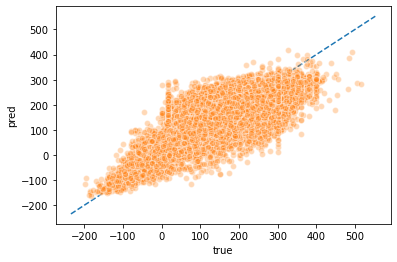

In [24]:
dmin=min(true.min(),pred.min())
dmax=max(true.max(),pred.max())
dmin,dmax = dmin-(dmax-dmin)*0.05,dmax+(dmax-dmin)*0.05

In [ ]:
import matplotlib.pyplot as plt

dmin=min(true.min(),pred.min())
dmax=max(true.max(),pred.max())

plt.hexbin(true-273,pred-273,gridsize=30,)
#plt.plot(true,pred,"o",)
plt.plot([dmin-273,dmax-273],[dmin-273,dmax-273],"--r",alpha=0.75)
plt.xlabel("true")
plt.ylabel("pred")
plt.show()
plt.close()
#plt.plot(np.exp(pred),np.exp(true),"o")
#plt.show()
#plt.close()

In [ ]:
import datetime
np.sqrt((np.abs(pred-true)**2).mean()),np.abs(pred-true).mean(),datetime.datetime.now()

In [ ]:
!nvidia-smi